In [ ]:
#BATTERY LEVEL AGNOSTIC PROTOTYPE

In [ ]:
%matplotlib inline

In [ ]:
import pulp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
np.random.seed(230228)
HMAX = 3000 #Maximum harvested energy

DMIN = 1 #20% duty cycle = 100 mWhr
DMAX = 5 #100% duty cycle = 500 mWhr
DSCALE = 100 #scale to convert action value to actual power consumption
NMAX = DMAX * DSCALE #max energy consumption

BMIN = 0.0
BMAX = 40000.0
BOPT = 0.6 * BMAX
BINIT = BOPT

In [ ]:
year = 2010
filename = str(year)+'.csv'

In [ ]:
#skiprows=4 to remove unnecessary title texts
#usecols=4 to read only the Global Solar Radiation (GSR) values
solar_radiation = pd.read_csv(filename, skiprows=4, encoding='shift_jisx0213', usecols=[4])

In [ ]:
#convert dataframe to numpy array
solar_radiation = solar_radiation.values
solar_energy = np.array([i *0.0165*1000000*0.15*1000/(60*60) for i in solar_radiation])

In [ ]:
#reshape solar_energy into no_of_daysx24 array
senergy = solar_energy.reshape(-1,24)
senergy[np.isnan(senergy)] = 0 #convert missing data in CSV files to zero

In [ ]:
def rewardfn(next_dist):
    mu = 0
    sig = 900
    
    if(np.abs(next_dist) <= 2400):
        return ((1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((next_dist - mu)/sig, 2.)/2)) * 1000000)
    else:
        return -100 - 0.05*np.abs(next_dist)

y = [rewardfn(x) for x in np.arange(-5000,5000)]
plt.plot(np.arange(-5000,5000),y)

In [ ]:
def get_henergy_state(henergy):
    if (henergy <= 0):
        henergy_state = 0
    elif (0 < henergy <= 100):
        henergy_state = 1
    elif (100 < henergy <= 500):
        henergy_state = 2
    elif (500 < henergy <= 2000):
        henergy_state = np.ceil(henergy/500) + 1
    else:
        henergy_state = 6
    
    return int(henergy_state)

y = [get_henergy_state(x) for x in np.arange(0.0,3000.0,0.5)]
plt.plot(y)

In [ ]:
def get_dist_state(dist):
    temp = np.ceil(np.abs(dist/1000))
    
    if (dist >= 0):
        dist_state = 21 - temp
    else:
        dist_state = 20 + temp
    
    dist_state = np.clip(dist_state, 0, 41)
    
    return int(dist_state)
    
y = [get_dist_state(x) for x in np.arange(-40000,40000)]
plt.plot(y)

In [ ]:
def choose_action(dist_state, henergy_state,  day_state, q):
    # This is how to choose an action
    q_values = q[dist_state, henergy_state,  day_state, :]
    max_q_value = np.max(q_values)
    max_action = np.argmax(q_values)
    if (np.random.uniform() < epsilon) or ((q_values == 0).all()):  # select randomly if exploring or 
                                                                         #if state-action values are ALL zero
        action = np.random.randint(1,no_of_actions)
    else:   # act greedy
        action = max_action
    return int(action)

In [ ]:
#function to map total day energy into day_state
def get_day_state(tot_day_energy):
    if (tot_day_energy < 2500):
        day_state = 0
    elif (2500 <= tot_day_energy < 5000):
        day_state = 1
    elif (5000 <= tot_day_energy < 8000):
        day_state = 2
    elif (8000 <= tot_day_energy < 10000):
        day_state = 3
    elif (10000 <= tot_day_energy < 12000):
        day_state = 4
    else:
        day_state = 5
        
    return int(day_state)

In [ ]:
#create a perfect forecaster
tot_day_energy = np.sum(senergy, axis=1) #contains total energy harvested on each day
get_day_state = np.vectorize(get_day_state)
forecast = get_day_state(tot_day_energy)

In [ ]:
from random import shuffle
sorted_days = []
for fcast in range(0,6):
    fcast_days = ([i for i,x in enumerate(forecast) if x == fcast])
    shuffle(fcast_days)
    sorted_days.append(fcast_days)

# print(sorted_days)

In [ ]:
# ##print tot_day energy
# f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
# ax1.plot(tot_day_energy)
# ax1.set_title('Total Energy')
# ax2.plot(forecast)
# ax2.set_title('Day State')
# plt.show()

In [ ]:
no_of_dist_state = 42;
no_of_henergy_state = 7;
no_of_day_state = 6;
no_of_actions = 5;

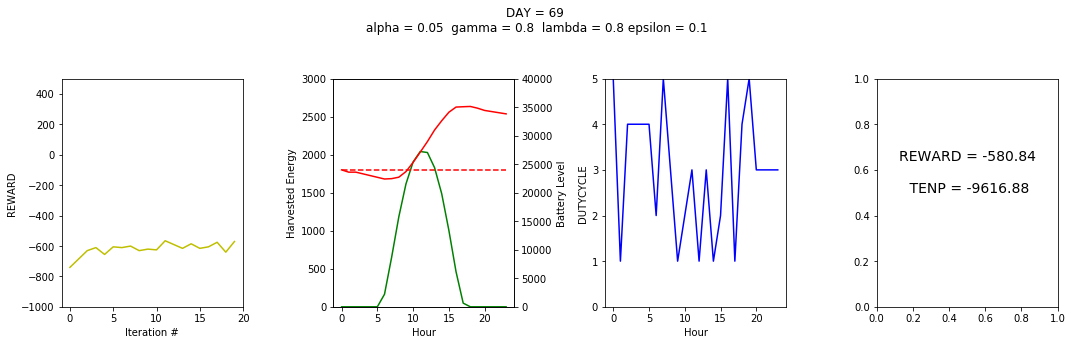

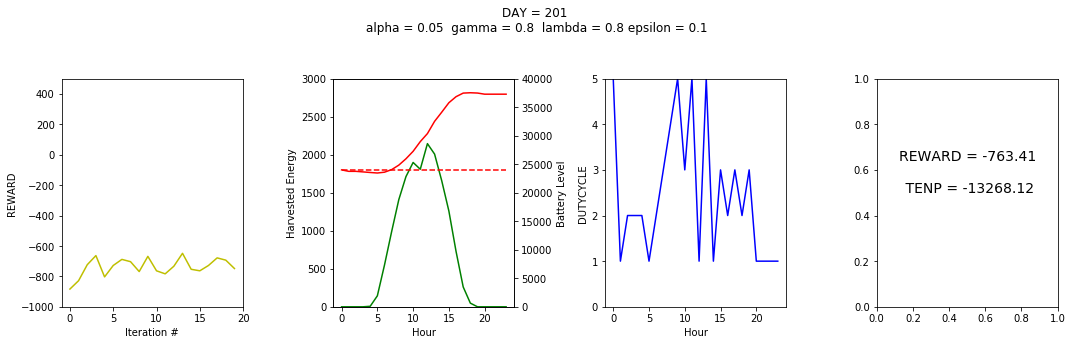

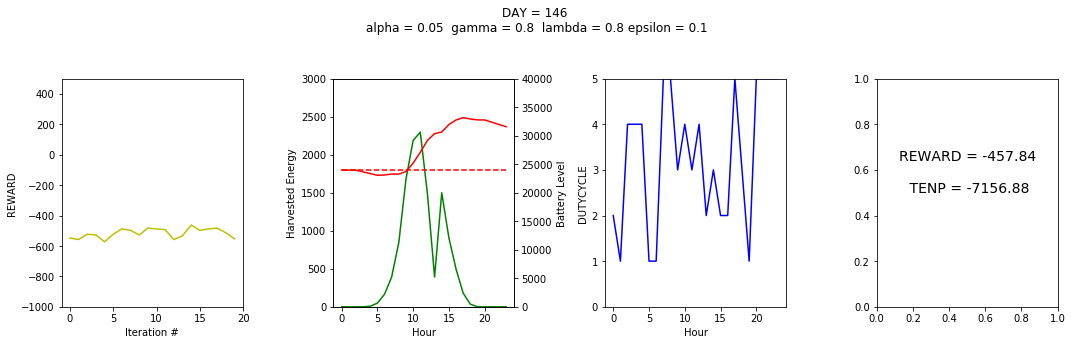

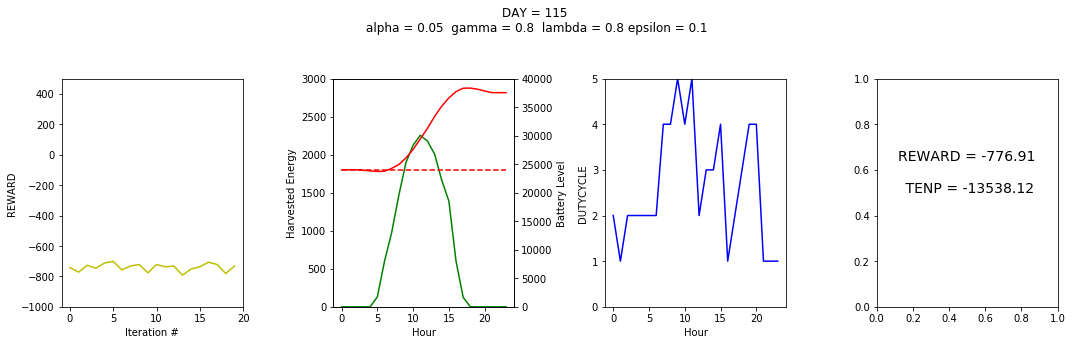

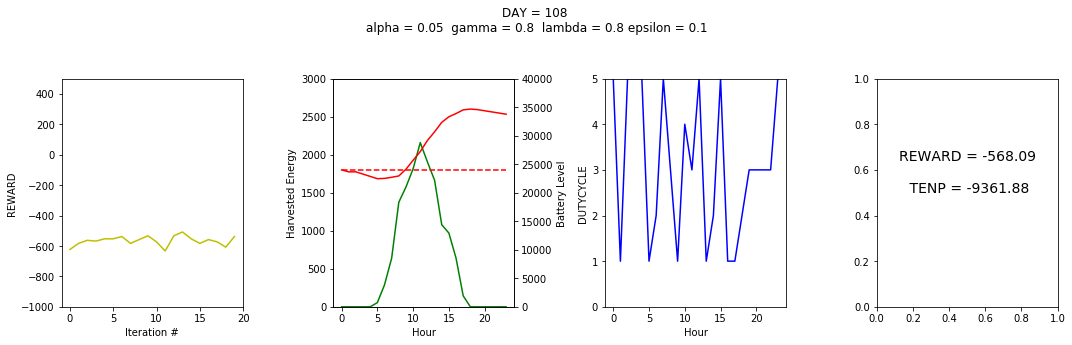

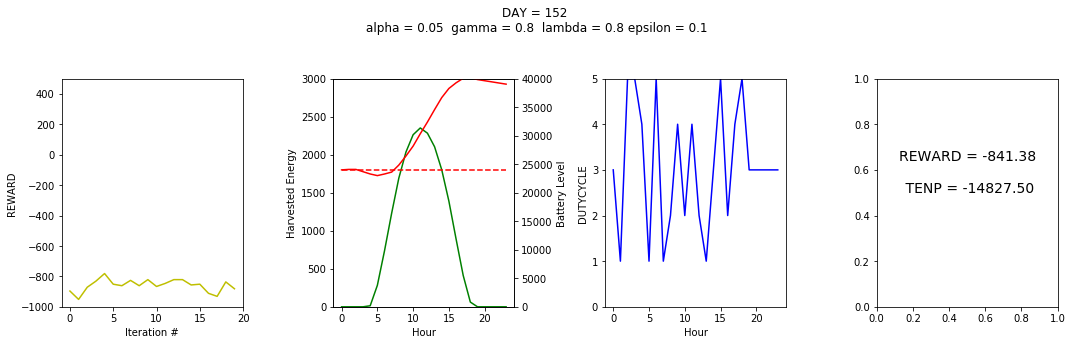

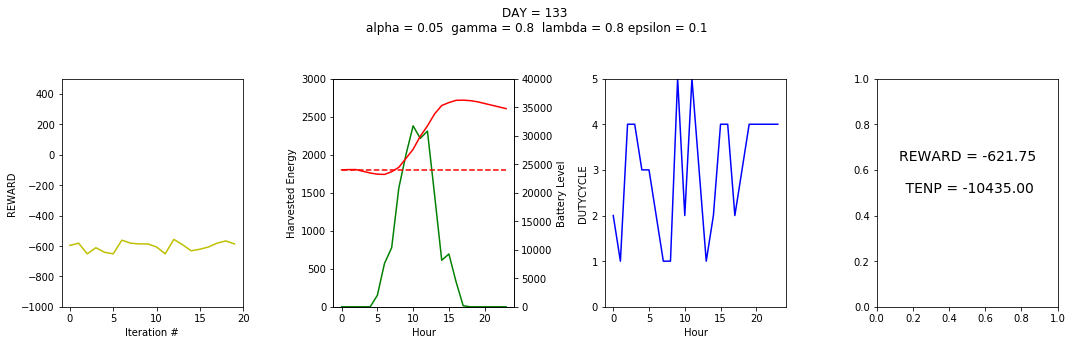

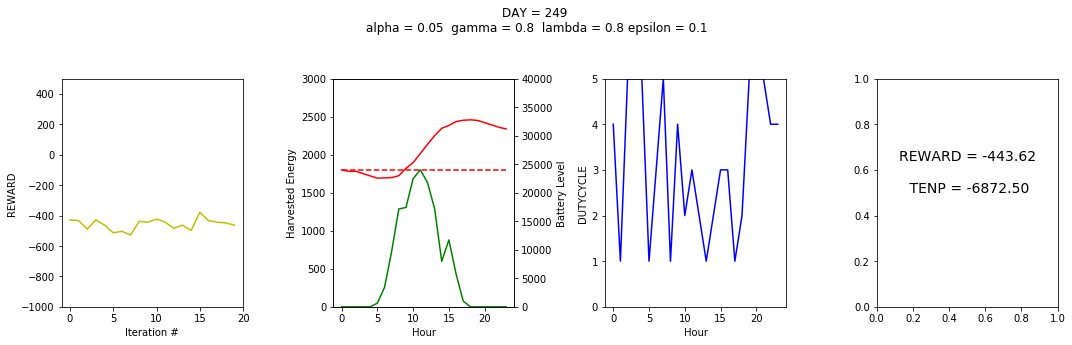

KeyboardInterrupt: 

In [64]:


day_state = 5 # type of day
IMAX = 20 #maximum number of iterations

#q_init is used for optimistic initialization of the Q-table to maximize exploration in the initial phases of training
q_init = 200;
q = np.zeros((no_of_dist_state, no_of_henergy_state, no_of_day_state, no_of_actions)) + q_init
e = np.zeros((no_of_dist_state, no_of_henergy_state, no_of_day_state, no_of_actions))  

for gamma in [0.8]: #discount factor
    for alpha in [0.05]: #learning rate
        for lmbda in [0.8]: #sarsa decay parameter
            for epsilon in [0.1]: #e-greedy rate

                for day in sorted_days[day_state]:
                    iteration = 0
                    day_enp_rec = np.zeros(0) #to record the ENP across the iteration
                    reward_rec = np.zeros(0) #to record the reward across the iteration
                    
                    #print("Training Day: {}" .format(day))
                    #for each day iterate IMAX times
                    while (iteration < IMAX):
                        #print("Iteration Number: {}" .format(iteration))

                        next_batt = BINIT #battery is initialized
                        #print("Battery Level: {} " .format(batt))

                        e = e*0 # eligibility traces are reset

                        next_dist = BINIT - next_batt  #distance from BOPT. Required to calculate dist_state.
                        next_henergy = senergy[day,5]
                        next_day_state = forecast[day]
                        action = np.random.randint(1,no_of_actions) #choose random action in the beginning

                        NO_OF_DAYS = senergy.shape[0]
                        TIME_STEPS = senergy.shape[1]
                        for hr in range(TIME_STEPS):

                            #Battery State AGNOSTIC
                            #Battery Energy
                            batt = next_batt
            #                 print("Battery = {}" .format(batt))
                            #batt_state = int(get_batt_state(batt))
                            #print("Battery State = {}" .format(batt_state))

                            #Distance from Energy Neutrality
                            dist = next_dist
            #                 print("EN Distance = {}" .format(dist))
                            dist_state = int(get_dist_state(dist))
            #                 print("EN Distance State = {}" .format(dist_state))

                            #Harvested Energy
                            henergy = next_henergy
            #                 print("Harvested Energy = {}" .format(henergy))
                            henergy_state = int(get_henergy_state(henergy))
            #                 print("Harvested Energy State = {}" .format(henergy_state))

                            #Weather Forecast State
                            day_state =  next_day_state
            #                 print("Weather Forecast State for day {} is {}.".format(day, day_state))

                            #STATE HAS BEEN DETERMINED
                            state = np.array([dist_state, henergy_state,  day_state])

                            #PRESENT ACTION
            #                 print("Action is {}.".format(action+1))

                            #CHOOSE NEXT ACTION
                            next_action = choose_action(dist_state, henergy_state, day_state, q)
            #                 print("Next Action is {}.".format(next_action+1))


                            #EXECUTE ACTION
                            next_batt = batt - action*100 + henergy
                            next_dist = BINIT - next_batt
                            next_dist_state = get_dist_state(next_dist)

                            if (hr < TIME_STEPS-1): #if the hour is not the last hour of the day
                                next_henergy = senergy[day, hr+1]
                                next_henergy_state = get_henergy_state(next_henergy)
                            else: #if the hour is the last hour of the day, then fetch energy from the first hour of the next day
                                if(day < NO_OF_DAYS-1): #if the day is not the last day of the year
                                    next_henergy = senergy[day+1, 0]
                                    next_henergy_state = get_henergy_state(next_henergy)
                                    next_day_state = forecast[day+1]
                                else: #if the hour is the last hour of the last day of the year, then shoganai - just assume the next day will be the same as the present day.
                                    next_henergy = senergy[day, 0]
                                    next_henergy_state = get_henergy_state(next_henergy)
                                    next_day_state = forecast[day]

                            #RECEIVE REWARD
                            if (hr == TIME_STEPS-1):
                                reward = rewardfn(next_dist)
            #                     print("Reward is {}.".format(reward))
            #                     print("ENP is {}.".format(next_dist))
                                day_enp_rec = np.append(day_enp_rec, next_dist) #record the ENP at the end of day
                                reward_rec = np.append(reward_rec, reward) #record the ENP at the end of day


                            #SARSA LAMBDA UPDATE
                            if (hr == TIME_STEPS-1):
                                del_ = reward - q[dist_state, henergy_state, day_state, action]
            #                     print("del@end = {}" .format(del_))
                            else:
                                del_ = gamma * q[next_dist_state, next_henergy_state, next_day_state, next_action] - q[dist_state, henergy_state, day_state, action]
            #                     print("del = {}" .format(del_))


                            #ELIGIBILITY TRACE AND Q-TABLE UPDATE
                            e[dist_state, henergy_state, day_state, action] += 1 #increase eligibility ONLY of the state-action pair just visited
                            qerr = alpha*del_*e
                            q = q + qerr
                            e = gamma*lmbda*e #decay eligibility trace for ALL state-action pairs by a fixed rate

                            #UPDATES FOR NEXT TIME STEPS
                            action = next_action
                            batt = next_batt
                            dist = next_dist
                            henergy = next_henergy

            #                 print("END OF HOUR {}\n\n".format(hr))
                        #END OF HOUR FOR LOOP
                        iteration += 1
                    #END OF ITERATION FOR LOOP
                    #
                    #
                    #
                    #
                    #
                    #AFTER COMPLETING ALL THE ITERATIOINS FOR TRAINING, WE TEST BY IMPLEMENTING THE GREEDY Q-TABLE
                    
                    batt_rec = np.zeros(0) #to record the battery level over a day after all iterations have finished
                    action_rec = np.zeros(0) #to record the duty cycle over a day after all iterations have finished
                    dist_rec = np.zeros(0) #to record the ENP at every hour of the day after all iterations have finished
                    
                    next_batt = BINIT #battery is initialized
                    next_dist = BINIT - next_batt  #distance from BOPT. Required to calculate dist_state.
                    next_henergy = senergy[day,5]
                    next_day_state = forecast[day]
                    action = np.random.randint(1,no_of_actions) #choose random action in the beginning

                    for hr in range(TIME_STEPS):
                        
                        action_rec = np.append(action_rec, action) #record the action
                        
                        #Battery State AGNOSTIC
                        #Battery Energy
                        batt = next_batt
                        batt_rec = np.append(batt_rec, batt) #record the battery values
        #                 print("Battery = {}" .format(batt))
                        #batt_state = int(get_batt_state(batt))
                        #print("Battery State = {}" .format(batt_state))

                        #Distance from Energy Neutrality
                        dist = next_dist
        #                 print("EN Distance = {}" .format(dist))
                        dist_state = int(get_dist_state(dist))
        #                 print("EN Distance State = {}" .format(dist_state))
                        dist_rec = np.append(dist_rec, dist) #record the ENP values

                        #Harvested Energy
                        henergy = next_henergy
        #                 print("Harvested Energy = {}" .format(henergy))
                        henergy_state = int(get_henergy_state(henergy))
        #                 print("Harvested Energy State = {}" .format(henergy_state))

                        #Weather Forecast State
                        day_state =  next_day_state
        #                 print("Weather Forecast State for day {} is {}.".format(day, day_state))

                        #STATE HAS BEEN DETERMINED
#                         state = np.array([dist_state, henergy_state,  day_state])

                        #PRESENT ACTION
        #                 print("Action is {}.".format(action+1))

                        #CHOOSE NEXT ACTION
                        q_values = q[dist_state, henergy_state,  day_state, :]
                        max_q_value = np.max(q_values)
                        next_action = np.argmax(q_values) #choose next action greedily
        #                 print("Next Action is {}.".format(next_action+1))


                        #EXECUTE ACTION
                        next_batt = batt - action*100 + henergy
                        next_dist = BINIT - next_batt
                        next_dist_state = get_dist_state(next_dist)

                        if (hr < TIME_STEPS-1): #if the hour is not the last hour of the day
                            next_henergy = senergy[day, hr+1]
                            next_henergy_state = get_henergy_state(next_henergy)
                        else: #if the hour is the last hour of the day, then fetch energy from the first hour of the next day
                            if(day < NO_OF_DAYS-1): #if the day is not the last day of the year
                                next_henergy = senergy[day+1, 0]
                                next_henergy_state = get_henergy_state(next_henergy)
                                next_day_state = forecast[day+1]
                            else: #if the hour is the last hour of the last day of the year, then shoganai - just assume the next day will be the same as the present day.
                                next_henergy = senergy[day, 0]
                                next_henergy_state = get_henergy_state(next_henergy)
                                next_day_state = forecast[day]

                                                             
                        #UPDATES FOR NEXT TIME STEPS
                        action = next_action
                        batt = next_batt
                        dist = next_dist
                        henergy = next_henergy
                    #END OF GREEDY IMPLEMENTATION FOR THE DAY
                    
                    treward = rewardfn(dist) #reward at the end of the day
                    tenp = dist #TENP at the end of the day

                    #PRINT RESULTS OF TRAINING FOR THE DAY
                    fig = plt.figure(figsize=(15,5))
                    st = fig.suptitle("DAY = %s \n alpha = %s  gamma = %s  lambda = %s epsilon = %s " %(day, alpha, gamma, lmbda, epsilon))
                    TIME_AXIS = np.arange(0,TIME_STEPS)


                    ax1 = fig.add_subplot(1,4,1)
                    ax1.plot(reward_rec,'y')
                    plt.ylabel("REWARD")
                    plt.xlabel("Iteration #")
                    ax1.set_ylim([-1000,500])

                    ax2a = fig.add_subplot(1,4,2)
                    ax2a.plot(TIME_AXIS, senergy[day,:],'g')
                    plt.ylabel("Harvested Energy")
                    plt.xlabel("Hour")
                    ax2a.set_ylim([0,HMAX])

                    ax2b = ax2a.twinx()
                    ax2b.plot(TIME_AXIS, batt_rec,'r')
                    ax2b.plot(TIME_AXIS, np.ones_like(batt_rec)*BINIT,'r--')
                    plt.ylabel("Battery Level")
                    plt.xlabel("Hour")
                    ax2b.set_ylim([0,BMAX])

    #                     ax3 = fig.add_subplot(1,4,3)
    #                     ax3.plot(dist_rec,'y')
    #                     ax3.plot(np.zeros_like(dist_rec),'y--')
    #                     plt.ylabel("ENP")
    #                     plt.xlabel("Hour")
    #                     ax3.set_ylim([-BMAX/2,BMAX/2])

                    ax4 = fig.add_subplot(1,4,3)
                    ax4.plot(action_rec+1,'b') #action 0 means dutcycle 1. It's more intuitive to display it like this in the plot.
                    plt.ylabel("DUTYCYCLE")
                    plt.xlabel("Hour")
                    ax4.set_ylim([0,DMAX])

                    ax5 = fig.add_subplot(1,4,4)
                    plt.text(0.5, 0.5, "REWARD = %.2f\n\n TENP = %.2f" %(treward, tenp),fontsize=14, ha='center')

                    fig.tight_layout()
                    st.set_y(0.95)
                    fig.subplots_adjust(top=0.75)
                    plt.show()
                #END OF DAY LOOP
            #end of epsilon loop
        #end of lmbda loop
    #end of alpha loop
#end of gamma loop



In [29]:
TIME_AXIS = np.arange(0,TIME_STEPS)
print(TIME_AXIS)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


In [ ]:
filename = "qtable_daystate_" + str(day_state) +".npy"
np.save(filename,q)

In [ ]:
_qdata = q[:,:,day_state,:]
qdata = np.where(_qdata==200,0,qdata)

In [ ]:
fig2 = plt.figure(figsize=(10,10))
ax1 = fig2.add_subplot(321, projection = '3d')
ax2 = fig2.add_subplot(322, projection = '3d')
ax3 = fig2.add_subplot(323, projection = '3d')
ax4 = fig2.add_subplot(324, projection = '3d')
ax5 = fig2.add_subplot(325, projection = '3d')

_x = np.arange(no_of_dist_state)
_y = np.arange(no_of_henergy_state)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, qdata[x,y,0], shade=True, color = 'r')
ax2.bar3d(x, y, bottom, width, depth, qdata[x,y,1], shade=True, color = 'y')
ax3.bar3d(x, y, bottom, width, depth, qdata[x,y,2], shade=True, color = 'g')
ax4.bar3d(x, y, bottom, width, depth, qdata[x,y,3], shade=True, color = 'b')
ax5.bar3d(x, y, bottom, width, depth, qdata[x,y,4], shade=True, color = 'm')

for ax in [ax1,ax2,ax3,ax4,ax5]:
    ax.set_xlabel('Distance')
    ax.set_ylabel('Harvested Energy')

fig2.tight_layout()
plt.show()

In [ ]:
#just checking if the file is there and stored properly
q = np.load(filename)

In [ ]:
#print only the greedy actions as a colormap
greedy = np.empty_like(q[:,:,0,0])

for i,j in np.ndindex(greedy.shape):
    greedy[i,j] = np.argmax(q[i,j,day_state:]) 

In [ ]:
from matplotlib.colors import ListedColormap

fig3 = plt.figure(figsize=(15,15))

my_cmap = ListedColormap(['r', 'y', 'g','b','m'])

ax1 = fig3.add_subplot(111)
cax = ax1.matshow(greedy, cmap=my_cmap)
fig3.colorbar(cax)

# _x = np.arange(no_of_dist_state)
# _y = np.arange(no_of_henergy_state)
# _xx, _yy = np.meshgrid(_x, _y)
# x, y = _xx.ravel(), _yy.ravel()

# bottom = np.zeros_like(top)
# width = depth = 1
